In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import scipy

from tqdm import tqdm

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
#ds_psl = xr.open_dataset("../CESM_data/CESM1LE_psl_NAtl_19200101_20051201.nc")
#ds_moc = xr.open_dataset("../CESM_data/CESM1LE_MOC_NAtl_20N-50N_19200101_20051201.nc")
ds_sst = xr.open_dataset("../CESM_data/CESM1LE_sst_NAtl_19200101_20051201.nc")

In [3]:
data = ds_sst['sst'][21:54,:,:,:].T.values
monthly_means = np.zeros((42,86,12,89,33))

In [4]:
iyr = 0
for it in range(1032):
    mo_ind = it%12
    monthly_means[:,iyr,mo_ind,:,:] = data[:,it,:,:]
    if mo_ind==11:
        iyr+=1
monthly_means = np.nanmean(monthly_means,axis=1)

<ipython-input-4-9b2b5952a412>:7: RuntimeWarning: Mean of empty slice
  monthly_means = np.nanmean(monthly_means,axis=1)


In [5]:
print(monthly_means.shape)
print(data.shape)

(42, 12, 89, 33)
(42, 1032, 89, 33)


In [6]:
data_deseason = np.zeros(data.shape)
for it in range(1032):
    mo_ind = it%12
    data_deseason[:,it,:,:] = data[:,it,:,:] - monthly_means[:,mo_ind,:,:]

In [7]:
data_deseason[np.isnan(data_deseason)] = 0

In [8]:
lead = 6
tstep = 1032

y = np.mean(data_deseason[:,lead:,:,:],axis=(2,3)).reshape((tstep-lead)*42,1)
X = data_deseason[:,0:tstep-lead,:,:].reshape((tstep-lead)*42,33,89)

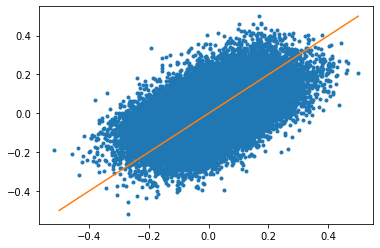

In [9]:
plt.plot( np.mean(X,axis=(1,2)), y,'.' )
plt.plot([-0.5,0.5],[-0.5,0.5])

In [10]:
shuffled_ind = np.arange(0,42*(tstep-lead),1)
np.random.seed(123)
np.random.shuffle(shuffled_ind)
X_shuffled = X[shuffled_ind,:,:].astype(np.float32)
y_shuffled = y[shuffled_ind].astype(np.float32)

In [11]:
X_shuffled.shape

(43092, 33, 89)

In [64]:
percent_train = 0.01


X_train = torch.from_numpy( X_shuffled[0:int(np.floor(percent_train*(tstep-lead)*42)),:,:].reshape( X_shuffled[0:int(np.floor(percent_train*(tstep-lead)*42)),:,:].shape[0],1,33,89 ))
y_train = torch.from_numpy( y_shuffled[0:int(np.floor(percent_train*(tstep-lead)*42)),:] )

X_val = torch.from_numpy( X_shuffled[int(np.floor(percent_train*(tstep-lead)*42)):,:,:].reshape( X_shuffled[int(np.floor(percent_train*(tstep-lead)*42)):,:,:].shape[0],1,33,89 ) )
y_val = torch.from_numpy( y_shuffled[int(np.floor(percent_train*(tstep-lead)*42)):,:] )

In [65]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


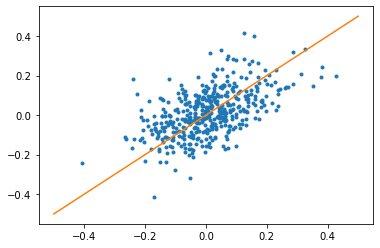

In [66]:
plt.plot( np.mean(X_train.numpy(),axis=(2,3)), y_train.numpy(),'.' )
plt.plot([-0.5,0.5],[-0.5,0.5])

In [67]:
model = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=5),
          nn.Flatten(),
          nn.Linear(in_features=5*17*32,out_features=128),
          nn.ReLU(),
          nn.Linear(in_features=128,out_features=64),
          nn.ReLU(),
          nn.Dropout(p=0.5),
          nn.Linear(in_features=64,out_features=1))

opt = torch.optim.Adadelta(model.parameters())
#opt = torch.optim.SGD(model.parameters(),lr = 1e-4)
loss_fn = nn.MSELoss()

Test loss before training 0.018881866708397865


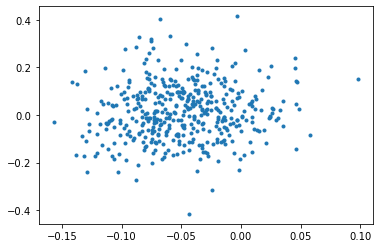

In [68]:
y_pred = model(X_train)
before_train = loss_fn(y_pred.squeeze(), y_train.squeeze())
print('Test loss before training' , before_train.item())
plt.plot(y_pred.detach().numpy(),y_train.numpy(),'.')

In [69]:
epoch = 100

epo_losses = []

model.train()

for i in tqdm(range(epoch)):
    # Forward pass
    y_pred = model(X_train)
    
    # Compute Loss
    loss = loss_fn(y_pred.squeeze(), y_train.squeeze())
    epo_losses.append(loss.item())
    
    # update
    opt.zero_grad()
    loss.backward()
    opt.step()

 27%|██▋       | 27/100 [00:13<00:36,  2.00it/s]


KeyboardInterrupt: 

Text(0, 0.5, 'loss')

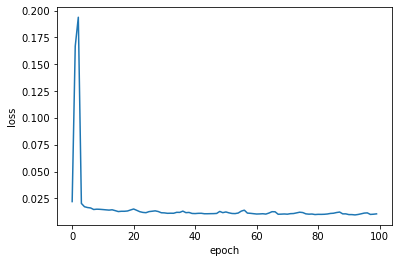

In [35]:
plt.plot(epo_losses)
plt.xlabel('epoch')
plt.ylabel('loss')

Test loss after Training 0.010172744281589985


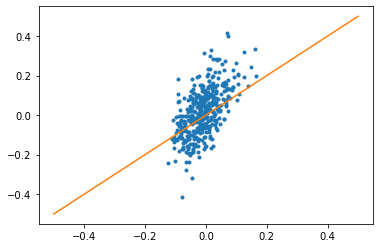

In [36]:
model.eval()
y_pred = model(X_train)
after_train = loss_fn(y_pred, y_train) 
print('Test loss after Training' , after_train.item())
plt.plot(y_pred.detach().numpy(),y_train.numpy(),'.')
plt.plot([-0.5,0.5],[-0.5,0.5])